In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
# from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
#from torchvision.datasets import CIFAR10
import torchvision.models as models
%matplotlib inline

In [2]:
data_dir = os.path.join(os.getcwd(),'notebook', 'fruits-360')
dataset_dir = os.path.join(data_dir, 'Training')
test_dir = os.path.join(data_dir, 'Test')

transform = transforms.Compose([
    transforms.ToTensor(), 
])

dataset = ImageFolder(dataset_dir, transform=transform)
test = ImageFolder(test_dir, transform=transform)

In [3]:
# Fixed rand. seed for reproducibility of results
random_seed = 21
torch.manual_seed(random_seed)

In [4]:
train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

train, val = random_split(dataset, [train_size, val_size])

print('Training data:   {} entries'.format(len(train)))
print('Validation data: {} entries'.format(len(val)))
print('Test data:       {} entries'.format(len(test)))

Training data:   872 entries
Validation data: 46 entries
Test data:       309 entries


In [5]:
# def show_example(img, label):
#     print('Label: ', dataset.classes[label], "("+str(label)+")")
#     plt.imshow(img.permute(1, 2, 0))

# show_example(*dataset[500])

In [6]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
# hyperparams
lr = 0.001
batch_size = 128
num_classes = len(dataset.classes)
num_epochs = 2
input_size = np.prod(dataset[0][0].shape)  # collapse all dimensions to calculate raw size

In [8]:
train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test, batch_size=batch_size*4, shuffle=False, num_workers=4)

In [9]:
# from torchvision.utils import make_grid

# def show_batch(dl):
#     for images, labels in dl:
#         fig, ax = plt.subplots(figsize=(12, 6))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
#         break
# show_batch(train_loader)

## 1. Feedforward Neural Network

In [10]:
# check training accuracy
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0    
    model.eval()  # turn on evaluation mode

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        print(f"Accuracy {float(num_correct) / float(num_samples) * 100:.2f}%")
    
    model.train()  # go back to training mode

In [11]:
# Inspired by: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/4bd862577ae445852da1c1603ade344d3eb03679/ML/Pytorch/Basics/pytorch_simple_fullynet.py
imsize = 100
# loader = transforms.Compose([transforms.ToTensor(), transforms.Scale((imsize, imsize)), transforms.ToTensor()])

class NN(nn.Module):
    def __init__(self, input_size, output_size):
        super(NN, self).__init__()
        self.linear_1 = nn.Linear(input_size, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 32)
        self.linear_4 = nn.Linear(32, output_size)

    def forward(self, x):        
        x = x.view(x.size(0), -1)
        out = self.linear_1(x)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.linear_3(out)
        out = F.relu(out)
        out = self.linear_4(out)
        return out

In [12]:
# initialise feedforward model
model = NN(input_size=input_size, output_size=num_classes)

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [14]:
# train network
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    for batch_idx, (data, targets) in enumerate(train_loader):
        print(f'\tBatch {batch_idx+1}')
        # use CUDA if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)

        # forward
        scores = model(data)
        loss = loss_fn(scores, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    check_accuracy(train_loader, model)
    check_accuracy(val_loader, model)

Epoch 1
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
Accuracy 100.00%
Accuracy 100.00%
Epoch 2
	Batch 1
	Batch 2
	Batch 3
	Batch 4
	Batch 5
	Batch 6
	Batch 7
Accuracy 100.00%
Accuracy 100.00%


In [15]:
check_accuracy(train_loader, model)

Accuracy 100.00%


In [16]:
check_accuracy(val_loader, model)

Accuracy 100.00%


In [17]:
check_accuracy(test_loader, model)

Accuracy 100.00%


In [18]:
# torch.save(model, 'avocado_classifier.pth')
# model = torch.load('avocado_classifier.pth')

In [19]:
model.eval()

NN(
  (linear_1): Linear(in_features=30000, out_features=128, bias=True)
  (linear_2): Linear(in_features=128, out_features=64, bias=True)
  (linear_3): Linear(in_features=64, out_features=32, bias=True)
  (linear_4): Linear(in_features=32, out_features=2, bias=True)
)

In [20]:
# source: tymokvo's reply @https://discuss.pytorch.org/t/how-to-classify-single-image-using-loaded-net/1411

from PIL import Image
from torch.autograd import Variable

imsize = 100
loader = transforms.Compose([transforms.Resize((imsize, imsize)), transforms.ToTensor()])

def image_loader(image_path):
    """load image, returns cuda tensor"""
    img = Image.open(image_path)
    img = loader(img).float()
    img = img.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return img

tensor([[0.0025, 0.9975]], grad_fn=<SoftmaxBackward>)

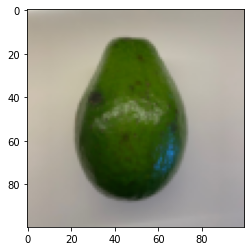

In [21]:
# Useful discussion: https://discuss.pytorch.org/t/how-can-my-net-produce-negative-outputs-when-i-use-relu/19483/3
image = image_loader('avocado_1.jpg')
plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
p_1 = F.softmax(model.forward(image))
p_1

tensor([[0.0132, 0.9868]], grad_fn=<SoftmaxBackward>)

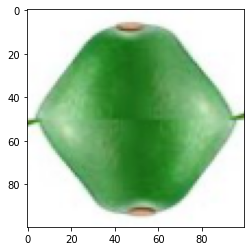

In [27]:
image = image_loader('avocado_9.jpg')
plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
p_2 = F.softmax(model.forward(image))
p_2

In [23]:
p, idx = p_2.max(1)
dataset.classes[idx]

'Avocado ripe'

In [24]:
ripeness = 'ripe' if (idx == 1).all() else 'unripe'
print('The avocado is {} with a {:.2f}% probability'.format(ripeness, p[0]*100))


The avocado is ripe with a 100.00% probability
